# Tarea 1: Exploración Geo-Temporal

In [3]:
import pandas as pd
import plotly.express as px

#Leer csv
df = pd.read_csv("data/agro_clean.csv")
df.head()

#Definición de columnas

LAT = "Latitude"      
LON = "Longitude"     

NDVI = "Agro_5"
HUM  = "Agro_1"


#Mapa

fig = px.scatter_mapbox(
    df,
    lat=LAT,
    lon=LON,
    color=NDVI,          # color por NDVI
    size=HUM,            # tamaño por humedad
    size_max=18,         # ajusta si quieres más grande/pequeño
    zoom=10,             # ajusta al área
    hover_data=[NDVI, HUM],
    title="Sensores: color=NDVI (Agro_5), tamaño=Humedad (Agro_1)"
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()





Pregunta: Existe algún patrón especial (clustering) donde la biomasa ser considerablemente alta?

Respuesta:


# Tarea 2: Análisis de estacionareidad y windowing

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv("data/ener_clean.csv")
df.head()

#Seleccionar series de energia
energy_cols = [c for c in df.columns if c.startswith("Ener_")]
energy_cols

#ADF
def adf_test(series: pd.Series, name: str = "", alpha: float = 0.05):
    s = series.dropna()
    result = adfuller(s, autolag="AIC")  # ADF
    p_value = result[1]
    test_stat = result[0]
    crit = result[4]
    is_stationary = p_value < alpha
    
    print(f"\nADF Test - {name}")
    print(f"  Test Statistic: {test_stat:.4f}")
    print(f"  p-value:        {p_value:.6f}")
    print("  Critical Values:")
    for k, v in crit.items():
        print(f"    {k}: {v:.4f}")
    print(f"  => {'Estacionaria' if is_stationary else 'NO estacionaria'} (alpha={alpha})")
    
    return is_stationary, p_value

#Resultado:
adf_results = {}

for col in energy_cols:
    is_stat, p = adf_test(df[col], name=col)
    adf_results[col] = {"stationary": is_stat, "p_value": p}

adf_results




ADF Test - Ener_1
  Test Statistic: -1.8669
  p-value:        0.347793
  Critical Values:
    1%: -3.4337
    5%: -2.8630
    10%: -2.5676
  => NO estacionaria (alpha=0.05)

ADF Test - Ener_2
  Test Statistic: -1.4791
  p-value:        0.543807
  Critical Values:
    1%: -3.4336
    5%: -2.8630
    10%: -2.5675
  => NO estacionaria (alpha=0.05)

ADF Test - Ener_3
  Test Statistic: -1.9284
  p-value:        0.318802
  Critical Values:
    1%: -3.4337
    5%: -2.8630
    10%: -2.5676
  => NO estacionaria (alpha=0.05)

ADF Test - Ener_4
  Test Statistic: -8464728266.6694
  p-value:        0.000000
  Critical Values:
    1%: -3.4336
    5%: -2.8630
    10%: -2.5675
  => Estacionaria (alpha=0.05)

ADF Test - Ener_5
  Test Statistic: -0.3477
  p-value:        0.918470
  Critical Values:
    1%: -3.4336
    5%: -2.8630
    10%: -2.5675
  => NO estacionaria (alpha=0.05)

ADF Test - Ener_6
  Test Statistic: 0.9527
  p-value:        0.993741
  Critical Values:
    1%: -3.4336
    5%: -2.8630
  

{'Ener_1': {'stationary': False, 'p_value': 0.3477932313370453},
 'Ener_2': {'stationary': False, 'p_value': 0.5438067534438151},
 'Ener_3': {'stationary': False, 'p_value': 0.31880198164292445},
 'Ener_4': {'stationary': True, 'p_value': 0.0},
 'Ener_5': {'stationary': False, 'p_value': 0.9184704540337367},
 'Ener_6': {'stationary': False, 'p_value': 0.9937409285971264},
 'Ener_7': {'stationary': False, 'p_value': 0.9059366267722364},
 'Ener_8': {'stationary': True, 'p_value': 0.0},
 'Ener_9': {'stationary': True, 'p_value': 0.0},
 'Ener_10': {'stationary': True, 'p_value': 0.0}}

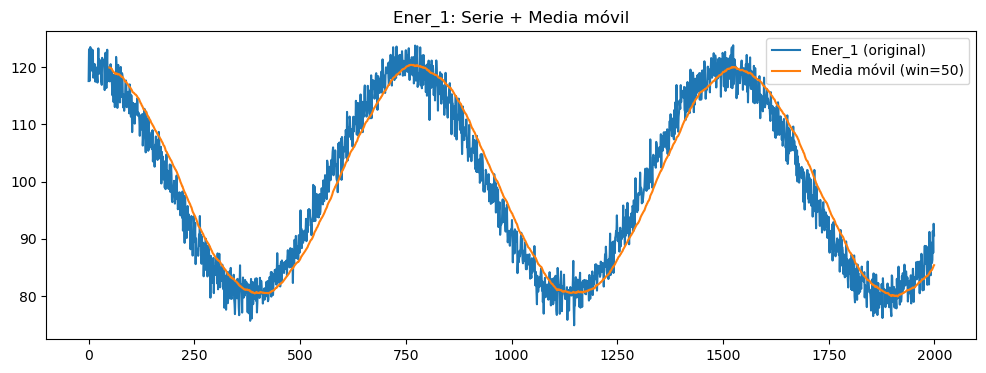

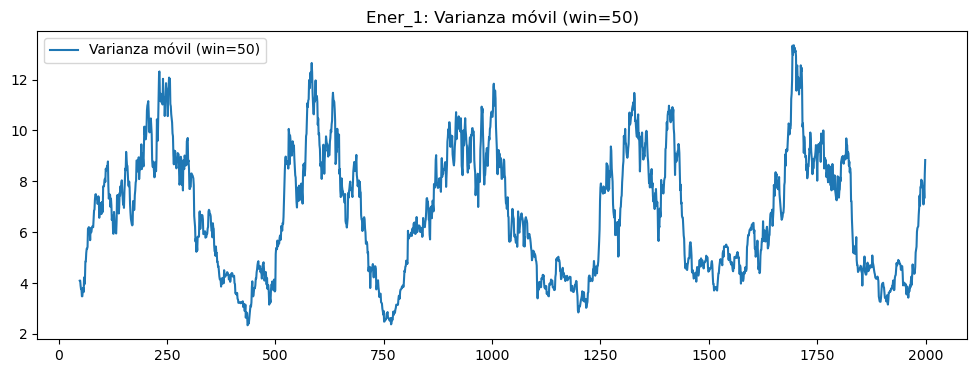

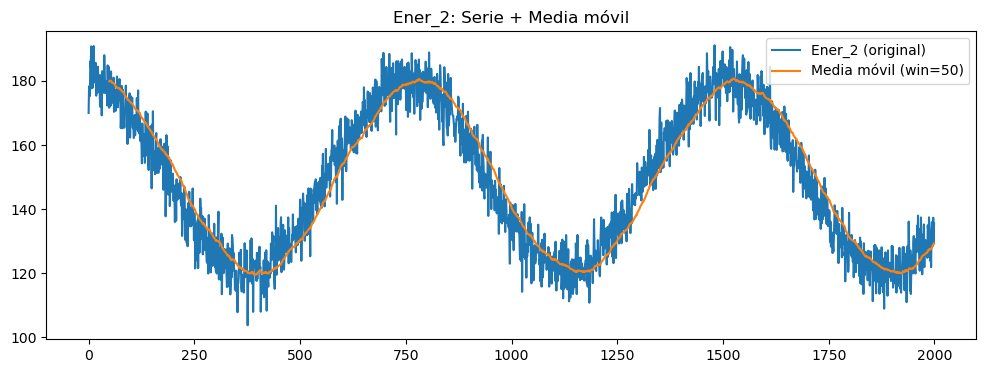

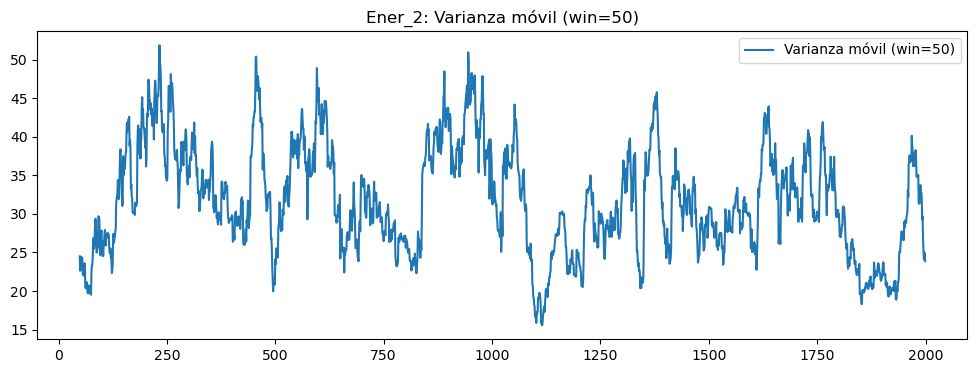

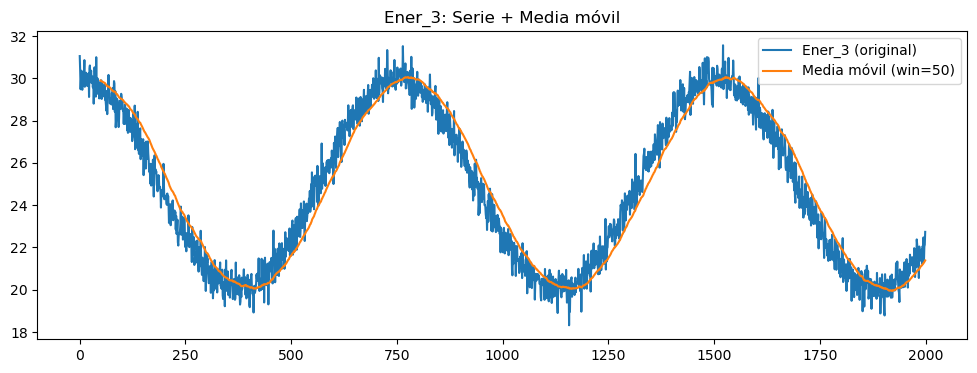

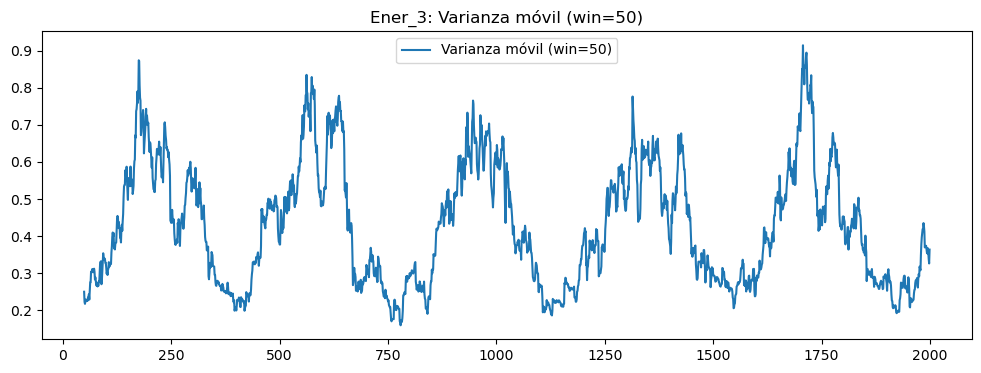

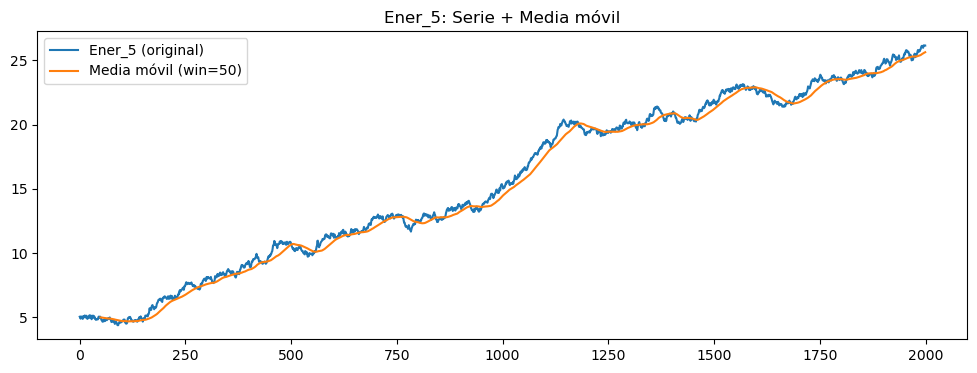

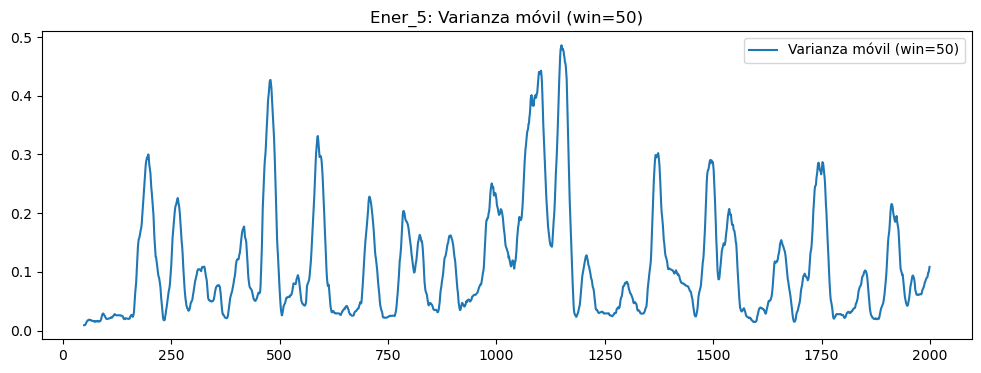

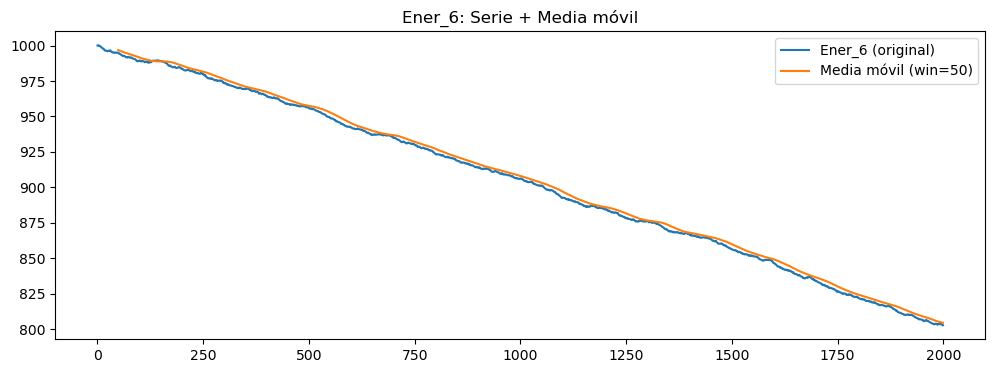

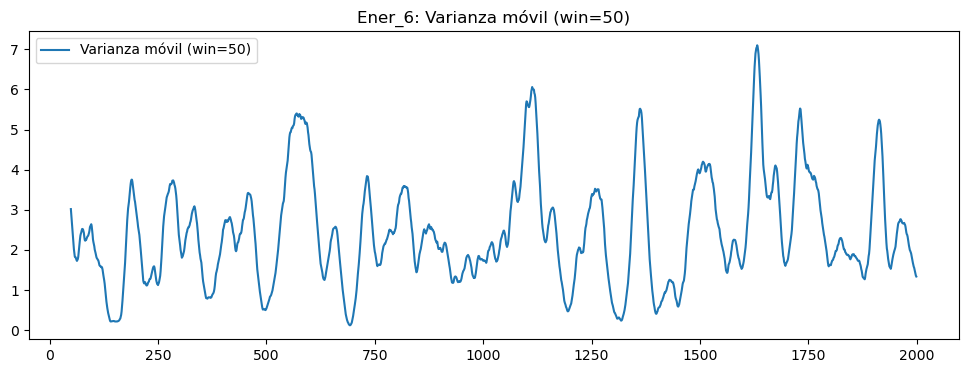

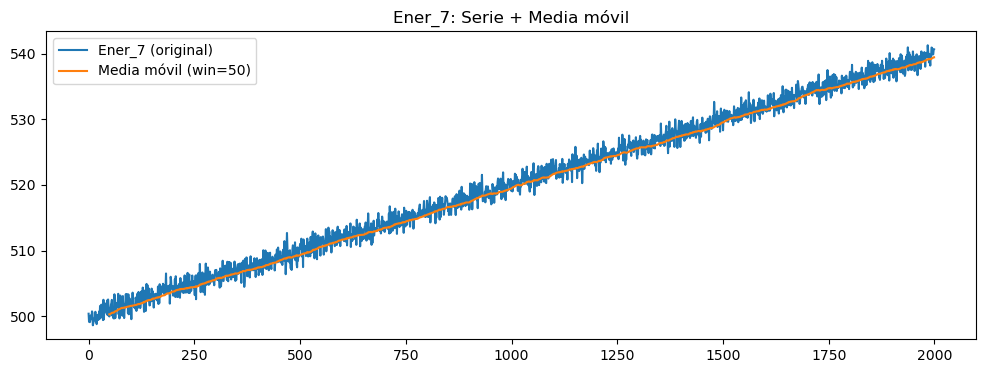

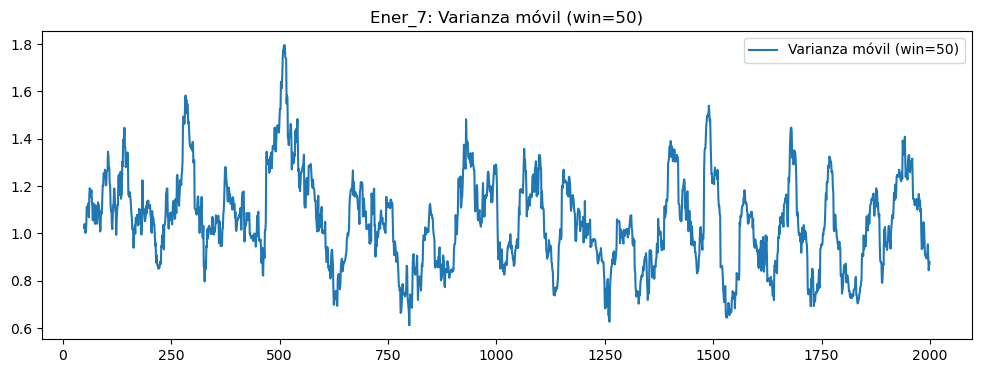

In [18]:
#PAra no estacionarias:

WINDOW = 50

for col in energy_cols:
    if not adf_results[col]["stationary"]:
        s = df[col].astype(float)

        rolling_mean = s.rolling(WINDOW).mean()
        rolling_var  = s.rolling(WINDOW).var()

        plt.figure(figsize=(12,4))
        plt.plot(s, label=f"{col} (original)")
        plt.plot(rolling_mean, label=f"Media móvil (win={WINDOW})")
        plt.title(f"{col}: Serie + Media móvil")
        plt.legend()
        plt.show()

        plt.figure(figsize=(12,4))
        plt.plot(rolling_var, label=f"Varianza móvil (win={WINDOW})")
        plt.title(f"{col}: Varianza móvil (win={WINDOW})")
        plt.legend()
        plt.show()


Pregunta: El costo del gas (Ener_5) es una serie con Drift o Random Walk

Respuesta: El gráfico de Ener_5 muestra una tendencia creciente sostenida en el tiempo.
La media móvil con ventana de 50 registros presenta una pendiente positiva clara,
lo que evidencia que la media no es constante.

Este comportamiento indica que la serie no es estacionaria y presenta un
componente de tendencia sistemática, compatible con un modelo tipo Random Walk
con drift positivo.

Por tanto, el Costo del Gas (Ener_5) no sigue un random walk puro, sino un
random walk con drift.

